In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import os
import json
from typing import Tuple
from tqdm import tqdm
from model_analysis.model_utils import *
from regression.regression_utils import get_train_test
sns.set(rc={"figure.figsize": (20, 10)})


In [2]:
PATH_TO_DATA = "analysis/data/"
REPETITIONS = 10

In [3]:
def df_to_train_data(df: pd.DataFrame) -> Tuple[np.array, np.array]:
    return df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), df.drop(columns=df.columns[:-1], axis=1)

def run_paredoes(index: int) -> pd.DataFrame:
    # Treinando em n-1 paredões para predizer o n-ésimo
    paredoes_df = {
        "repeticao": [],
        "paredao": [],
        "eliminado": [],
        "rejeicao": [],
        "modelo": [],
        "pred": [],
        "pred_pct": [],
    }
    paredoes = len(os.listdir(PATH_TO_DATA))

    for model in tqdm(MODELS.keys(), desc="- Modelos analisados"):
        
        params = PARAMETERS[model]
        regressor_model = MODELS[model]

        for paredao in range(1, paredoes):
            regressor = regressor_model(**params)
            if NORMALIZE[model]:
                train_df, test_df, mean, std = get_train_test(paredao, normalize=True, drop_columns=REMOVE, data_path=PATH_TO_DATA)
            else:
                train_df, test_df = get_train_test(paredao, normalize=False, drop_columns=REMOVE,  data_path=PATH_TO_DATA)

            x_train, y_train = df_to_train_data(train_df)
            x_test, y_test = df_to_train_data(test_df)

            y_train, y_test = np.ravel(y_train), np.ravel(y_test)

            regressor.fit(x_train, y_train)
            prediction = regressor.predict(x_test)

            if NORMALIZE[model]:
                test_df["predicao"] = prediction * std + mean
                test_df["rejeicao"] =  test_df["rejeicao"] * std + mean
            else:
                test_df["predicao"] = prediction
            
            pred_elimination, pred_pct = test_df.sort_values(by="predicao", ascending=False)[["nome", "predicao"]].iloc[0] 
            true_elimination, true_pct = test_df.sort_values(by="rejeicao", ascending=False)[["nome", "rejeicao"]].iloc[0]
            
            paredoes_df["repeticao"].append(index)
            paredoes_df["paredao"].append(paredao)
            paredoes_df["eliminado"].append(true_elimination)
            paredoes_df["rejeicao"].append(true_pct)
            paredoes_df["modelo"].append(model)
            paredoes_df["pred"].append(pred_elimination)
            paredoes_df["pred_pct"].append(pred_pct)
    
    return pd.DataFrame(paredoes_df)

In [4]:
paredoes_analysis_df = run_paredoes(0)
for index in range(1, REPETITIONS): paredoes_analysis_df = paredoes_analysis_df.append(run_paredoes(index), ignore_index=True)

- Modelos analisados: 100%|██████████| 11/11 [00:20<00:00,  1.89s/it]


In [5]:
paredoes_analysis_df.head()

,repeticao,paredao,eliminado,rejeicao,modelo,pred,pred_pct
0,0,1,lucas_chumbo,0.7594,linear_regression,lucas_chumbo,0.975834
1,0,2,petrix,0.8027,linear_regression,petrix,0.453233
2,0,3,hadson,0.7971,linear_regression,hadson,0.647271
3,0,4,lucas,0.6262,linear_regression,lucas,0.519301
4,0,5,bianca_andrade,0.5309,linear_regression,felipe_prior,0.583902


# Contagem de acertos

In [6]:
paredoes_analysis_df["erro_absoluto"] = abs(paredoes_analysis_df["rejeicao"] - paredoes_analysis_df["pred_pct"])
paredoes_analysis_df["acertos"] = paredoes_analysis_df["eliminado"] == paredoes_analysis_df["pred"]

In [7]:
paredoes_analysis_df[paredoes_analysis_df["repeticao"] == 0]

,repeticao,paredao,eliminado,rejeicao,modelo,pred,pred_pct,erro_absoluto,acertos
0,0,1,lucas_chumbo,0.7594,linear_regression,lucas_chumbo,0.975834,0.216434,True
1,0,2,petrix,0.8027,linear_regression,petrix,0.453233,0.349467,True
2,0,3,hadson,0.7971,linear_regression,hadson,0.647271,0.149829,True
3,0,4,lucas,0.6262,linear_regression,lucas,0.519301,0.106899,True
4,0,5,bianca_andrade,0.5309,linear_regression,felipe_prior,0.583902,0.053002,False
...,...,...,...,...,...,...,...,...,...
182,0,13,flayslene,0.6300,ensamble2,flayslene,0.515692,0.114308,True
183,0,14,gizelly_bicalho,0.5479,ensamble2,babu,0.546317,0.001583,False
184,0,15,ivy,0.7417,ensamble2,ivy,0.440352,0.301348,True
185,0,16,mari,0.5416,ensamble2,mari,0.352277,0.189323,True


In [8]:
paredoes_analysis_df.to_csv("paredoes.csv")

In [9]:
resultados_medios = paredoes_analysis_df.groupby(["modelo", "paredao"]).mean()
resultados_medios["acertos"] = paredoes_analysis_df[["modelo", "paredao", "acertos"]].groupby(["modelo", "paredao"]).sum().values
resultados_medios.drop(["repeticao", "rejeicao"], axis=1, inplace=True)
resultados_medios.reset_index(inplace=True)


In [10]:
resultados_medios

,modelo,paredao,pred_pct,erro_absoluto,acertos
0,ada_boost,1,0.772791,0.016931,10.0
1,ada_boost,2,0.695196,0.107504,10.0
2,ada_boost,3,0.580183,0.216917,10.0
3,ada_boost,4,0.485028,0.141172,9.0
4,ada_boost,5,0.545586,0.017811,0.0
...,...,...,...,...,...
182,svm,13,0.527035,0.102965,10.0
183,svm,14,0.629974,0.082074,0.0
184,svm,15,0.397766,0.343934,10.0
185,svm,16,0.389955,0.151645,10.0


In [11]:
acertos_medios = resultados_medios[["modelo", "acertos"]].groupby("modelo").sum()
acertos_medios /= REPETITIONS

In [12]:
acertos_medios.sort_values(by="acertos", ascending=False)

,acertos
modelo,
svm,15.0
ensamble2,14.4
ensamble3,14.0
ada_boost,13.5
ridge,13.0
sgd,12.4
random_forest,12.3
knn,12.0
linear_regression,12.0


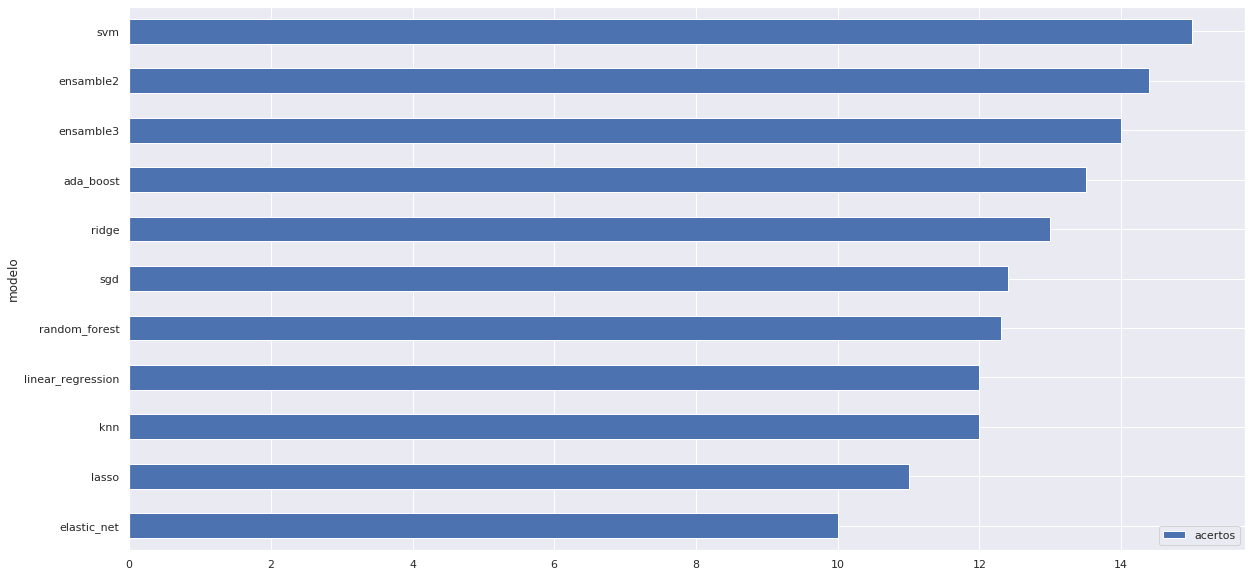

In [13]:
acertos_medios.sort_values(by="acertos").plot.barh()

# Análise de erro absoluto por paredão

In [14]:
resultados_medios.sort_values(by="paredao", inplace=True)
erro_df = resultados_medios.set_index("paredao").pivot(columns="modelo")


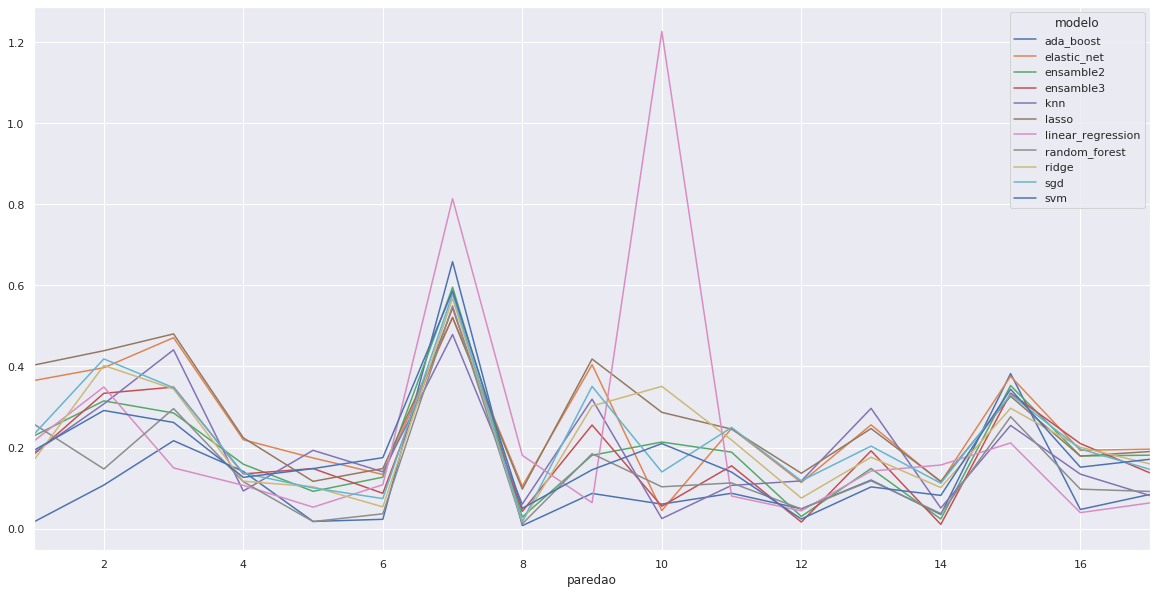

In [15]:
erro_df["erro_absoluto"].plot()

# Acertos em cada paredão

In [16]:
# TODO: Montar uma visualização